### Classification

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('df_v3.csv',low_memory=False)

In [3]:
df = df.dropna(subset=['holders_count', 'inventor_count', 'abstract_length','patent_family_size'])
print(df.isnull().sum())

patent_id                      0
patent_date                    0
num_claims                     0
nominal_market_value           0
real_market_value              0
forward_citations              0
classification_scope           0
non_patent_forward_ref         0
type_of_claim                  0
extended_patent_family_size    0
abstract_length                0
patent_family_size             0
holders_count                  0
inventor_count                 0
dtype: int64


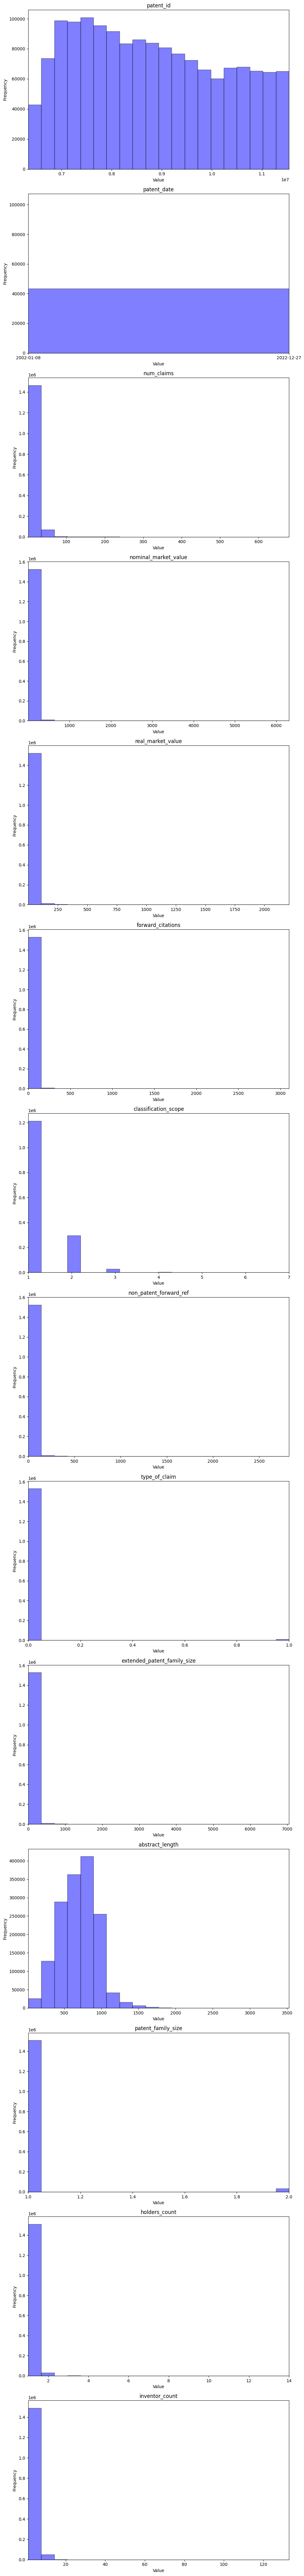

In [4]:
# Create a figure and axis for each column
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(10, 6 * len(df.columns)))

# Loop through each column and create a histogram
for i, col in enumerate(df.columns):
    data = df[col]
    min_value = data.min()  # Calculate the minimum value for the current column
    max_value = data.max()  # Calculate the maximum value for the current column

    axes[i].hist(data, bins=20, alpha=0.5, color='b', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

    # Set individual x-axis limits for each column
    axes[i].set_xlim(min_value, max_value)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


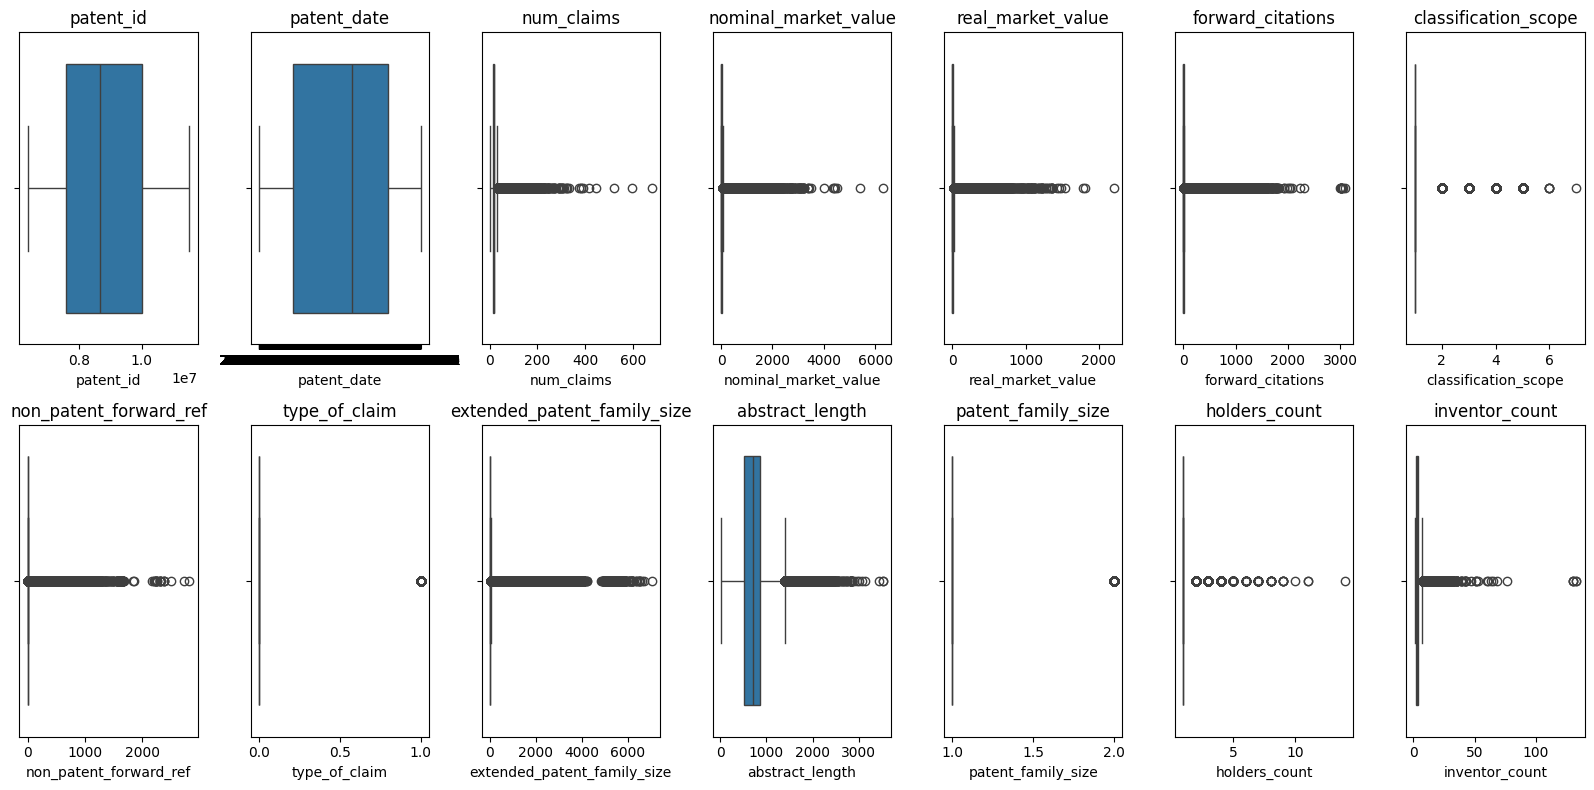

In [14]:
plt.figure(figsize=(16, 8))
num_columns = len(df.columns)
num_rows = 2

num_plots = num_rows * 2

for i, col in enumerate(df.columns):
    plt.subplot(num_rows, num_columns // num_rows, i + 1)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

### Drop Outliers

In [5]:
df = df.iloc[:, 2:]
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,num_claims,nominal_market_value,real_market_value,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count
count,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000,1541266.00000
mean,17.97607,28.40972,11.47636,8.05181,1.23499,9.31922,0.00648,27.58794,692.99018,1.02151,1.02307,3.06575
std,10.45109,73.76543,28.77083,39.92523,0.47862,38.64798,0.08023,128.71853,248.30476,0.14506,0.16705,2.08426
min,1.00000,0.00033,0.00017,0.00000,1.00000,0.00000,0.00000,0.00000,17.00000,1.00000,1.00000,1.00000
25%,12.00000,1.35135,0.57500,0.00000,1.00000,0.00000,0.00000,4.00000,514.00000,1.00000,1.00000,2.00000
50%,18.00000,7.93966,3.35541,1.00000,1.00000,1.00000,0.00000,9.00000,702.00000,1.00000,1.00000,3.00000
75%,20.00000,25.21868,10.52958,5.00000,1.00000,6.00000,0.00000,19.00000,870.00000,1.00000,1.00000,4.00000
max,679.00000,6305.39001,2207.32299,3102.00000,7.00000,2823.00000,1.00000,7048.00000,3525.00000,2.00000,14.00000,133.00000


In [6]:
# Define the columns for which you want to remove outliers
columns_to_check = ['num_claims',
 'nominal_market_value',
 'real_market_value',
 'forward_citations',
 'classification_scope',
 'non_patent_forward_ref',
 'extended_patent_family_size',
 'abstract_length',
 'inventor_count']

# Calculate the Z-scores for the selected columns
z_scores = df[columns_to_check].apply(stats.zscore)

# Define a threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Identify rows where any of the selected columns has a Z-score greater than the threshold
outlier_rows = (z_scores.abs() > threshold).any(axis=1)

# Remove rows with outliers from the DataFrame
df_no_outliers = df[~outlier_rows]


In [12]:
features = df_no_outliers.drop(columns=['nominal_market_value','real_market_value'])

In [13]:
features.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,num_claims,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count
count,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000,1404945.00000
mean,17.10864,5.31614,1.19393,5.62746,0.00671,18.43768,689.38430,1.02040,1.02214,2.91828
std,7.93972,12.39947,0.39538,12.84214,0.08163,34.41417,235.69403,0.14138,0.16274,1.73362
min,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,17.00000,1.00000,1.00000,1.00000
25%,12.00000,0.00000,1.00000,0.00000,0.00000,4.00000,516.00000,1.00000,1.00000,2.00000
50%,18.00000,1.00000,1.00000,1.00000,0.00000,9.00000,702.00000,1.00000,1.00000,3.00000
75%,20.00000,5.00000,1.00000,5.00000,0.00000,18.00000,867.00000,1.00000,1.00000,4.00000
max,49.00000,127.00000,2.00000,125.00000,1.00000,413.00000,1437.00000,2.00000,14.00000,9.00000


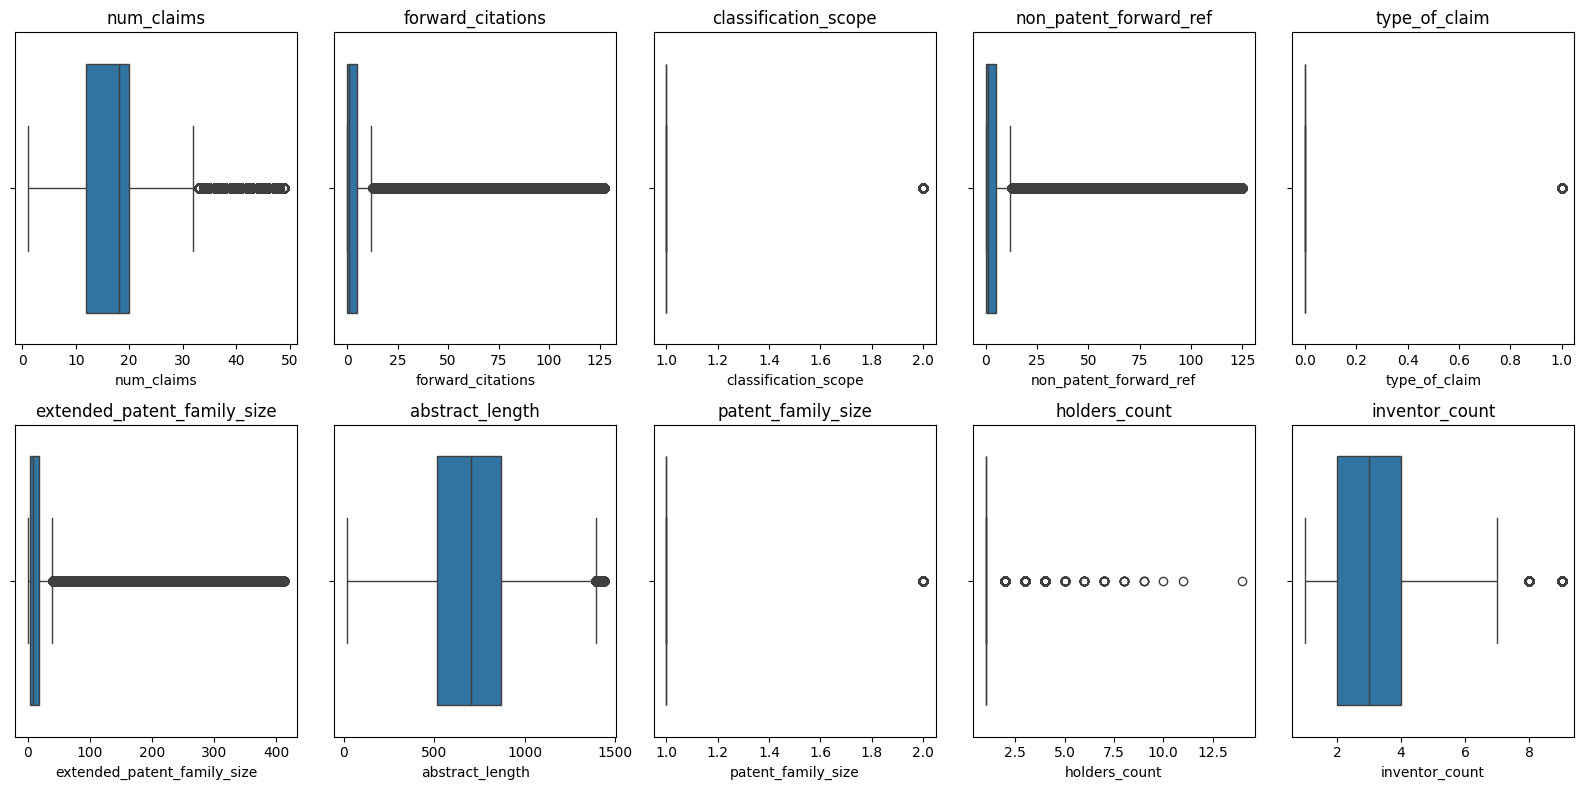

In [14]:
plt.figure(figsize=(16, 8))
num_columns = len(features.columns)
num_rows = 2

num_plots = num_rows * 2

for i, col in enumerate(features.columns):
    plt.subplot(num_rows, num_columns // num_rows, i + 1)
    sns.boxplot(x=features[col])
    plt.title(col)

plt.tight_layout()
plt.show()


In [15]:
columns_to_label = ['num_claims', 'forward_citations', 'non_patent_forward_ref', 'extended_patent_family_size', 'abstract_length']

thresholds = features[columns_to_label].quantile(0.95)

def set_label(row):
    for col in columns_to_label:
        if row[col] > thresholds[col]:
            return 1
    return 0

features['label'] = features.apply(set_label, axis=1)

features


,num_claims,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count,label
0,20,8.0,1.0,6.0,0,3.0,950.0,1.0,1.0,1.0,0
1,18,2.0,2.0,2.0,0,7.0,768.0,1.0,1.0,3.0,0
2,4,0.0,1.0,2.0,0,11.0,847.0,1.0,1.0,2.0,0
3,20,0.0,1.0,3.0,0,9.0,1018.0,1.0,1.0,5.0,0
5,11,0.0,1.0,1.0,0,3.0,971.0,1.0,1.0,9.0,0
...,...,...,...,...,...,...,...,...,...,...,...
2532246,13,0.0,1.0,0.0,0,10.0,649.0,1.0,1.0,2.0,0
2532248,15,4.0,1.0,5.0,0,2.0,927.0,1.0,1.0,5.0,0
2532249,14,1.0,2.0,1.0,0,5.0,567.0,1.0,1.0,1.0,0
2532250,16,1.0,1.0,1.0,0,3.0,487.0,1.0,1.0,4.0,0


In [16]:
features[features['label']==1]

,num_claims,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count,label
20,20,1.0,2.0,6.0,0,265.0,701.0,1.0,1.0,6.0,1
60,24,7.0,1.0,6.0,0,88.0,743.0,1.0,1.0,2.0,1
64,33,0.0,2.0,39.0,0,83.0,716.0,1.0,1.0,6.0,1
77,14,1.0,1.0,36.0,0,28.0,188.0,1.0,1.0,5.0,1
83,35,0.0,1.0,7.0,0,20.0,840.0,1.0,1.0,6.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2532152,34,1.0,2.0,17.0,0,2.0,859.0,1.0,1.0,2.0,1
2532154,25,34.0,2.0,23.0,0,41.0,180.0,1.0,1.0,4.0,1
2532178,20,8.0,1.0,11.0,0,185.0,364.0,2.0,1.0,2.0,1
2532204,14,0.0,2.0,0.0,0,77.0,886.0,2.0,1.0,3.0,1


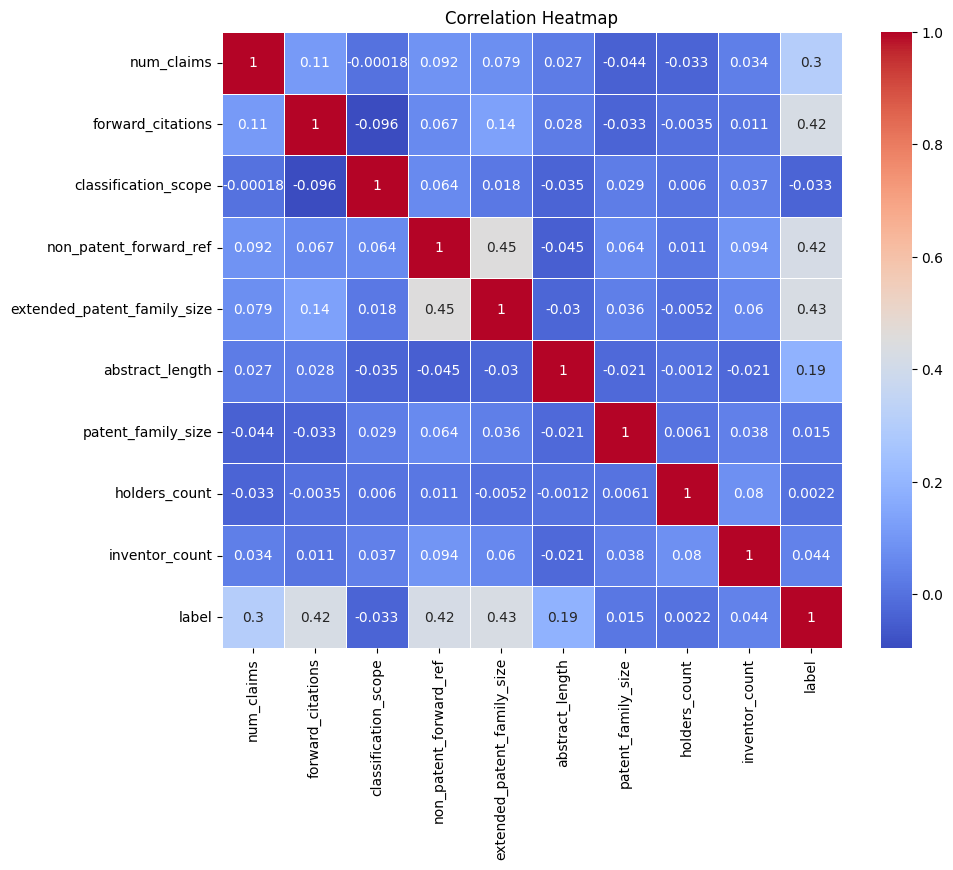

In [17]:
features = features.drop(columns=['type_of_claim'])
correlation_matrix = features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [18]:
X = features[['num_claims','forward_citations','classification_scope','non_patent_forward_ref','extended_patent_family_size',
              'abstract_length','patent_family_size','holders_count','inventor_count']]
X

,num_claims,forward_citations,classification_scope,non_patent_forward_ref,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count
0,20,8.0,1.0,6.0,3.0,950.0,1.0,1.0,1.0
1,18,2.0,2.0,2.0,7.0,768.0,1.0,1.0,3.0
2,4,0.0,1.0,2.0,11.0,847.0,1.0,1.0,2.0
3,20,0.0,1.0,3.0,9.0,1018.0,1.0,1.0,5.0
5,11,0.0,1.0,1.0,3.0,971.0,1.0,1.0,9.0
...,...,...,...,...,...,...,...,...,...
2532246,13,0.0,1.0,0.0,10.0,649.0,1.0,1.0,2.0
2532248,15,4.0,1.0,5.0,2.0,927.0,1.0,1.0,5.0
2532249,14,1.0,2.0,1.0,5.0,567.0,1.0,1.0,1.0
2532250,16,1.0,1.0,1.0,3.0,487.0,1.0,1.0,4.0


In [19]:
y = features['label']
y

0          0
1          0
2          0
3          0
5          0
          ..
2532246    0
2532248    0
2532249    0
2532250    0
2532251    0
Name: label, Length: 1404945, dtype: int64

### Stratified sampling

In [20]:
from sklearn.model_selection import train_test_split


#Select 70% of the samples with label 1 as the training set
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X[y==1], y[y==1], test_size=0.3, random_state=42)

#Select 70% of the samples with label 0 as the training set
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X[y==0], y[y==0], test_size=0.3, random_state=42)

# Merge the training set and test set of the two labels
X_train = pd.concat([X_train_0, X_train_1])
X_test = pd.concat([X_test_0, X_test_1])
y_train = pd.concat([y_train_0, y_train_1])
y_test = pd.concat([y_test_0, y_test_1])


### Logistic Regression

In [26]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Create a logistic regression model
model_LR = LogisticRegression()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Fit the logistic regression model on the training data
model_LR.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred = model_LR.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate precision, recall, and f1-score
classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9110120431617807
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.95    339370
           1       0.84      0.67      0.75     82114

    accuracy                           0.91    421484
   macro avg       0.88      0.82      0.85    421484
weighted avg       0.91      0.91      0.91    421484

ROC AUC Score: 0.8196803800339789


In [12]:
X_scaled = scaler.fit_transform(X)
y_pred = model_LR.predict(X_scaled)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
features['predicted_LR']=y_pred
features

/tmp/ipykernel_18225/1604032683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['predicted_LR']=y_pred


,patent_id,patent_date,num_claims,nominal_market_value,real_market_value,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count,label,predicted_LR
0,10000000,2018-06-19,20,63.837809,24.799967,8.0,1.0,6.0,0,3.0,950.0,1.0,1.0,1.0,0,0
1,10000003,2018-06-19,18,59.673756,23.182299,2.0,2.0,2.0,0,7.0,768.0,1.0,1.0,3.0,0,0
2,10000005,2018-06-19,4,0.442509,0.171907,0.0,1.0,2.0,0,11.0,847.0,1.0,1.0,2.0,0,0
3,10000010,2018-06-19,20,4.654450,1.808179,0.0,1.0,3.0,0,9.0,1018.0,1.0,1.0,5.0,0,0
5,10000019,2018-06-19,11,39.378884,15.298066,0.0,1.0,1.0,0,3.0,971.0,1.0,1.0,9.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532246,9958836,2018-05-01,13,7.223449,2.806194,0.0,1.0,0.0,0,10.0,649.0,1.0,1.0,2.0,0,0
2532248,9958848,2018-05-01,15,12.676470,4.924606,4.0,1.0,5.0,0,2.0,927.0,1.0,1.0,5.0,0,0
2532249,9958849,2018-05-01,14,138.246845,53.706687,1.0,2.0,1.0,0,5.0,567.0,1.0,1.0,1.0,0,0
2532250,9958852,2018-05-01,16,12.676470,4.924606,1.0,1.0,1.0,0,3.0,487.0,1.0,1.0,4.0,0,0


### Random Forest

In [41]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

rf_classifier = RandomForestClassifier(n_estimators=10, max_depth=5, criterion='gini')

rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 0.0013428742253561226
Root Mean Squared Error (RMSE): 0.03664524833257543
Mean Absolute Error (MAE): 0.0013428742253561226
R-squared (R2): 0.9914393475163881


In [42]:
accuracy = round(accuracy_score(y_test, y_pred), 5)
precision = round(precision_score(y_test, y_pred), 5)
recall = round(recall_score(y_test, y_pred), 5)
f1 = round(f1_score(y_test, y_pred), 5)
auc = round(roc_auc_score(y_test, y_pred), 5)

In [43]:
print(accuracy)
print(precision)
print(recall)
print(f1)
print(auc)

0.99866
1.0
0.99311
0.99654
0.99655


In [15]:
pred_RF = rf_classifier.predict(X)
features['predicted_RF']=pred_RF
features

/tmp/ipykernel_18225/3288477759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['predicted_RF']=pred_RF


,patent_id,patent_date,num_claims,nominal_market_value,real_market_value,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count,label,predicted_LR,predicted_RF
0,10000000,2018-06-19,20,63.837809,24.799967,8.0,1.0,6.0,0,3.0,950.0,1.0,1.0,1.0,0,0,0
1,10000003,2018-06-19,18,59.673756,23.182299,2.0,2.0,2.0,0,7.0,768.0,1.0,1.0,3.0,0,0,0
2,10000005,2018-06-19,4,0.442509,0.171907,0.0,1.0,2.0,0,11.0,847.0,1.0,1.0,2.0,0,0,0
3,10000010,2018-06-19,20,4.654450,1.808179,0.0,1.0,3.0,0,9.0,1018.0,1.0,1.0,5.0,0,0,0
5,10000019,2018-06-19,11,39.378884,15.298066,0.0,1.0,1.0,0,3.0,971.0,1.0,1.0,9.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532246,9958836,2018-05-01,13,7.223449,2.806194,0.0,1.0,0.0,0,10.0,649.0,1.0,1.0,2.0,0,0,0
2532248,9958848,2018-05-01,15,12.676470,4.924606,4.0,1.0,5.0,0,2.0,927.0,1.0,1.0,5.0,0,0,0
2532249,9958849,2018-05-01,14,138.246845,53.706687,1.0,2.0,1.0,0,5.0,567.0,1.0,1.0,1.0,0,0,0
2532250,9958852,2018-05-01,16,12.676470,4.924606,1.0,1.0,1.0,0,3.0,487.0,1.0,1.0,4.0,0,0,0


### ANN

In [36]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical  

X_valid = X_test
y_valid = y_test
# Define the ANN model
model_ann = keras.Sequential([
    keras.layers.Dense(100, input_shape=(X_train.shape[1],), activation='sigmoid'),
    keras.layers.Dense(2, activation='softmax')  
])

# Compile the model with categorical cross-entropy loss and adam optimizer
model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# One-hot encode labels
y_train_onehot = to_categorical(y_train, num_classes=2)
y_valid_onehot = to_categorical(y_valid, num_classes=2)  

# Train the model with validation data
history = model_ann.fit(X_train, y_train_onehot, epochs=2, batch_size=32, validation_data=(X_valid, y_valid_onehot), verbose=1)

# Evaluate the model on validation data
validation_loss, validation_accuracy = model_ann.evaluate(X_valid, y_valid_onehot)

# Print validation loss and accuracy
print(f"Validation Loss: {validation_loss}")
print(f"Validation Accuracy: {validation_accuracy}")


2023-10-08 21:12:14.658012: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-08 21:12:14.832102: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 21:12:14.832131: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 21:12:14.833077: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 21:12:14.915392: I tensorflow/core/platform/cpu_feature_g

Epoch 1/2
30734/30734 [==============================] - 51s 2ms/step - loss: 0.1261 - accuracy: 0.9518 - val_loss: 0.0859 - val_accuracy: 0.9675
Epoch 2/2
13172/13172 [==============================] - 16s 1ms/step - loss: 0.0925 - accuracy: 0.9644
Validation Loss: 0.092549629509449
Validation Accuracy: 0.9644114375114441


In [37]:
y_pred_proba = model_ann.predict(X_valid)
y_pred = np.argmax(y_pred_proba, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred)

# Calculate precision
precision = precision_score(y_valid, y_pred)

# Calculate recall
recall = recall_score(y_valid, y_pred)

# Calculate F1 score
f1 = f1_score(y_valid, y_pred)

# Calculate AUC
auc = roc_auc_score(y_valid, y_pred_proba[:, 1])

13172/13172 [==============================] - 15s 1ms/step


In [39]:
print(accuracy)
print(precision)
print(recall)
print(f1)
print(auc)

0.96441146045876
0.8911984145488459
0.9309861899310714
0.910657915113107
0.9917080688687916


In [17]:
y_pred_ann = model_ann.predict(X)

43905/43905 [==============================] - 45s 1ms/step


In [22]:
predicted_ANN = np.argmax(y_pred_ann, axis=1)
predicted_ANN

array([0, 0, 0, ..., 0, 0, 0])

In [28]:
predicted_ANN.shape

(1404945,)

In [19]:
predicted_ANN = predicted_ANN.shape[0]

In [29]:
features['predicted_ANN'] = predicted_ANN
features

/tmp/ipykernel_18225/2982742066.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['predicted_ANN'] = predicted_ANN


,patent_id,patent_date,num_claims,nominal_market_value,real_market_value,forward_citations,classification_scope,non_patent_forward_ref,type_of_claim,extended_patent_family_size,abstract_length,patent_family_size,holders_count,inventor_count,label,predicted_LR,predicted_RF,predicted_ANN
0,10000000,2018-06-19,20,63.837809,24.799967,8.0,1.0,6.0,0,3.0,950.0,1.0,1.0,1.0,0,0,0,0
1,10000003,2018-06-19,18,59.673756,23.182299,2.0,2.0,2.0,0,7.0,768.0,1.0,1.0,3.0,0,0,0,0
2,10000005,2018-06-19,4,0.442509,0.171907,0.0,1.0,2.0,0,11.0,847.0,1.0,1.0,2.0,0,0,0,0
3,10000010,2018-06-19,20,4.654450,1.808179,0.0,1.0,3.0,0,9.0,1018.0,1.0,1.0,5.0,0,0,0,1
5,10000019,2018-06-19,11,39.378884,15.298066,0.0,1.0,1.0,0,3.0,971.0,1.0,1.0,9.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2532246,9958836,2018-05-01,13,7.223449,2.806194,0.0,1.0,0.0,0,10.0,649.0,1.0,1.0,2.0,0,0,0,0
2532248,9958848,2018-05-01,15,12.676470,4.924606,4.0,1.0,5.0,0,2.0,927.0,1.0,1.0,5.0,0,0,0,0
2532249,9958849,2018-05-01,14,138.246845,53.706687,1.0,2.0,1.0,0,5.0,567.0,1.0,1.0,1.0,0,0,0,0
2532250,9958852,2018-05-01,16,12.676470,4.924606,1.0,1.0,1.0,0,3.0,487.0,1.0,1.0,4.0,0,0,0,0


In [30]:
features.to_csv('predited_value.csv',index=False)